In [1]:
import sys
if sys.version_info[0] < 3:
  print('[ERROR] You need to run this with Python 3.')
  raise AssertionError

# ______________________________________________________________________________
import numpy as np

from emtf_algos import *
from emtf_logger import *

In [2]:
import sys
import os
#os.environ['KERAS_BACKEND'] = 'tensorflow'

# Set random seed
np.random.seed(2027)

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers as k_layers
from tensorflow.keras import backend as k_backend
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set random seed
tf.random.set_seed(2027)

#import numba
#from numba import njit, vectorize
#import dask
#import dask.array as da

logger = get_logger()
logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using python     : {0}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(tf.config.list_physical_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))
#logger.info('Using numba      : {0}'.format(numba.__version__))
#logger.info('Using dask       : {0}'.format(dask.__version__))

assert k_backend.backend() == 'tensorflow'
assert k_backend.image_data_format() == 'channels_last'

%matplotlib inline

[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 3.6.10 |Anaconda, Inc.| (default, May  8 2020, 02:54:21) [GCC 7.3.0]
[INFO    ] Using numpy      : 1.18.5
[INFO    ] Using tensorflow : 2.2.0
[INFO    ] Using keras      : 2.3.0-tf
[INFO    ] .. list devices  : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]
[INFO    ] Using matplotlib : 3.2.2


In [3]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(-1,0,+1)
timezone = 1

maxevents = 100
#maxevents = -1

# Input files
patterns_fname = 'patterns_zone%i.npz' % zone
zone_images_fname = 'zone_images_zone%i.h5' % zone

#logger.info('Processing zone {0} timezone {1}'.format(zone, timezone))
#logger.info('.. maxevents        : {0}'.format(maxevents))

In [4]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# Color maps
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
my_cmap.set_under('w',1)

from matplotlib.colors import LinearSegmentedColormap
cdict = {
  'blue' : ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
blue_hot = LinearSegmentedColormap('blue_hot', cdict)

cdict = {
  'blue' : ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
green_hot = LinearSegmentedColormap('green_hot', cdict)

### Load data

In [5]:
def load_patterns(fname):
  logger.info('Loading from {0}'.format(fname))
  with np.load(fname) as loaded:
    patterns = loaded['patterns']
    boxes_act = loaded['boxes_act']
    logger.info('patterns: {0} boxes_act: {1}'.format(patterns.shape, boxes_act.shape))
  return (patterns, boxes_act)

import h5py
loaded_h5 = None  # hdf5 file handle

def load_zone_sparse_images(fname):
  global loaded_h5
  if loaded_h5 is None:
    logger.info('Loading from {0}'.format(fname))
    loaded_h5 = h5py.File(fname, 'r')
  zone_sparse_images = SparseTensorValue(indices=loaded_h5['zone_sparse_images_indices'],
                                         values=loaded_h5['zone_sparse_images_values'],
                                         dense_shape=loaded_h5['zone_sparse_images_dense_shape'])
  logger.info('zone_sparse_images: {0}'.format(zone_sparse_images.dense_shape))
  return zone_sparse_images

In [6]:
def sparse_to_dense_quick(sparse, maxevents):
  dense_shape = (maxevents,) + sparse.dense_shape[1:]
  dense = np.zeros(dense_shape, dtype=sparse.dtype)
  for i in range(len(sparse.indices)):
    if sparse.indices[i, 0] >= maxevents:
      break
    tup = tuple(sparse.indices[i])
    dense[tup] = sparse.values[i]
  return dense

In [7]:
patterns, boxes_act = load_patterns(patterns_fname)

boxes_act_test = boxes_act[3]  # use only the prompt muon row
boxes_act_test = np.moveaxis(boxes_act_test, 0, -1)  # put num_patterns at the last axis

logger.info('boxes_act_test: {0}'.format(boxes_act_test.shape))

[INFO    ] Loading from patterns_zone0.npz
[INFO    ] patterns: (7, 7, 8, 3) boxes_act: (7, 7, 8, 111, 1)
[INFO    ] boxes_act_test: (8, 111, 1, 7)


In [8]:
zone_sparse_images = load_zone_sparse_images(zone_images_fname)

zone_images_test = sparse_to_dense_quick(zone_sparse_images, maxevents)

logger.info('zone_images_test: {0}'.format(zone_images_test.shape))

[INFO    ] Loading from zone_images_zone0.h5
[INFO    ] zone_sparse_images: (762362, 8, 300, 1)
[INFO    ] zone_images_test: (100, 8, 300, 1)


In [9]:
# Image format & box image format
image_format = zone_images_test.shape[1:]
box_image_format = boxes_act_test.shape[:-1]
(num_rows, num_cols, num_channels) = image_format
(num_box_rows, num_box_cols, num_box_channels) = box_image_format
box_col_offset = (num_box_cols-1)//2  # (111-1)/2 = 55
num_patterns = boxes_act_test.shape[-1]

logger.info('Processing zone {0} timezone {1}'.format(zone, timezone))
logger.info('.. maxevents        : {0}'.format(maxevents))
logger.info('.. image_format     : {0}'.format(image_format))
logger.info('.. box_image_format : {0}'.format(box_image_format))
logger.info('.. num_patterns     : {0}'.format(num_patterns))

[INFO    ] Processing zone 0 timezone 1
[INFO    ] .. maxevents        : 100
[INFO    ] .. image_format     : (8, 300, 1)
[INFO    ] .. box_image_format : (8, 111, 1)
[INFO    ] .. num_patterns     : 7


### Create model

In [10]:
def create_model():
  # Input
  inputs = keras.Input(shape=(num_rows, num_cols, num_channels))
  x = inputs

  # Transpose the input, exchanging row <-> channel
  from tensorflow.python.ops import array_ops
  x = array_ops.transpose(x, perm=(0, 3, 2, 1))  # NHWC -> NCWH

  # Conv2D
  # See: https://www.tensorflow.org/api_docs/python/tf/keras/layers/DepthwiseConv2D
  conv2d_kwargs = dict(kernel_size=(1, num_box_cols), depth_multiplier=num_patterns,
                       strides=(1, 1), padding='same', activation=None, use_bias=False)
  x = k_layers.DepthwiseConv2D(**conv2d_kwargs)(x)

  # Reshape + reverse transpose
  x = array_ops.reshape(x, [-1, num_channels, num_cols, num_rows, num_patterns])
  x = array_ops.transpose(x, perm=(0, 3, 2, 1, 4))  # NCWHX -> NHWCX
  x = array_ops.reshape(x, [-1, num_rows, num_cols, num_channels * num_patterns])

  # Output
  outputs = x

  # Model
  model = keras.Model(inputs=inputs, outputs=outputs, name='some_model')
  model.summary()
  return model

In [11]:
# Create model

model = create_model()

Model: "some_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 300, 1)]       0         
_________________________________________________________________
tf_op_layer_Transpose (Tenso [(None, 1, 300, 8)]       0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 300, 56)        6216      
_________________________________________________________________
tf_op_layer_Reshape (TensorF [(None, 1, 300, 8, 7)]    0         
_________________________________________________________________
tf_op_layer_Transpose_1 (Ten [(None, 8, 300, 1, 7)]    0         
_________________________________________________________________
tf_op_layer_Reshape_1 (Tenso [(None, 8, 300, 7)]       0         
Total params: 6,216
Trainable params: 6,216
Non-trainable params: 0
______________________________________________________

In [12]:
# Find weight names

model_weights = model.get_weights()
#print(len(model_weights))

from collections import defaultdict
model_weights_w_names = defaultdict(list)

# Loop over layer weights
i = 0
for model_layer in model.layers:
  for _ in model_layer.weights:
    logger.info('layer {0}. {1}: {2}'.format(i, model_layer.name, model_weights[i].shape))
    model_weights_w_names[model_layer.name].append(model_weights[i])
    i += 1

boxes_act_test_transposed = np.transpose(boxes_act_test, [2, 1, 0, 3])

assert len(model_weights) == num_channels
assert model_weights[0].shape == boxes_act_test_transposed.shape

# Set weights
model.set_weights([boxes_act_test_transposed])

[INFO    ] layer 0. depthwise_conv2d: (1, 111, 8, 7)


### Inference

In [13]:
# Inference

zone_featmaps_test = model(zone_images_test)
zone_featmaps_test = zone_featmaps_test.numpy().astype(np.bool)

### Results

In [14]:
# Display images

def display_image(img, cmap=blue_hot, figsize=(10,2)):
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto',
            cmap=cmap, vmin=0, vmax=1.6)
  ax.set_yticks(range(len(zo_layer_labels[zone])))
  ax.set_yticklabels(zo_layer_labels[zone], fontsize=7)
  ax.grid(False)
  plt.show()

Event 0


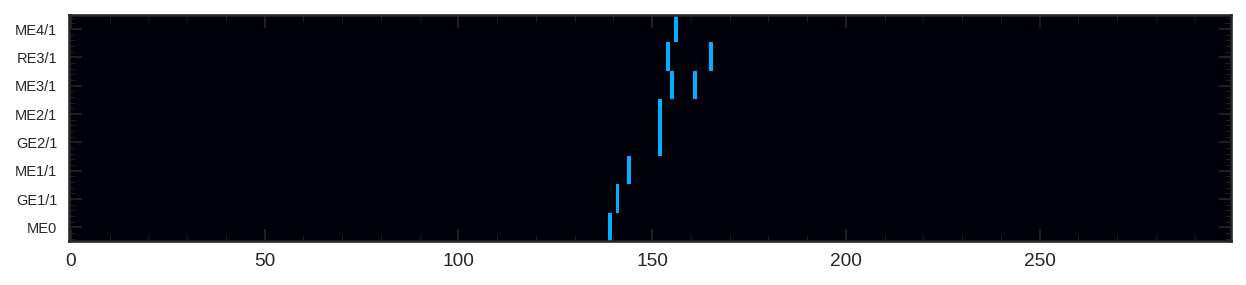

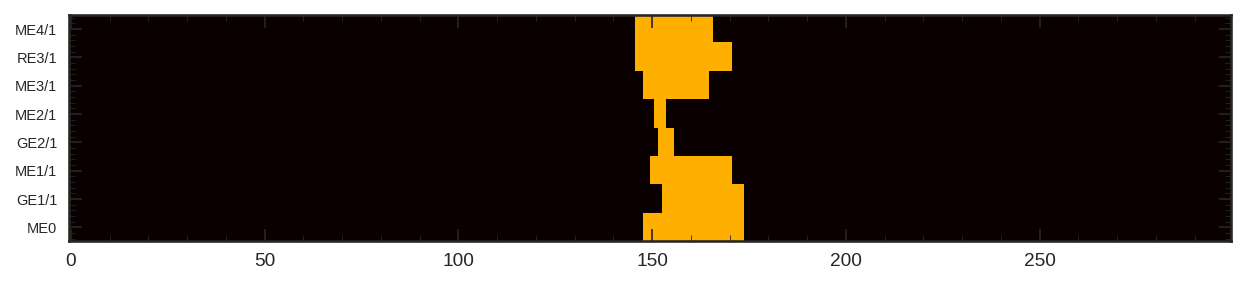

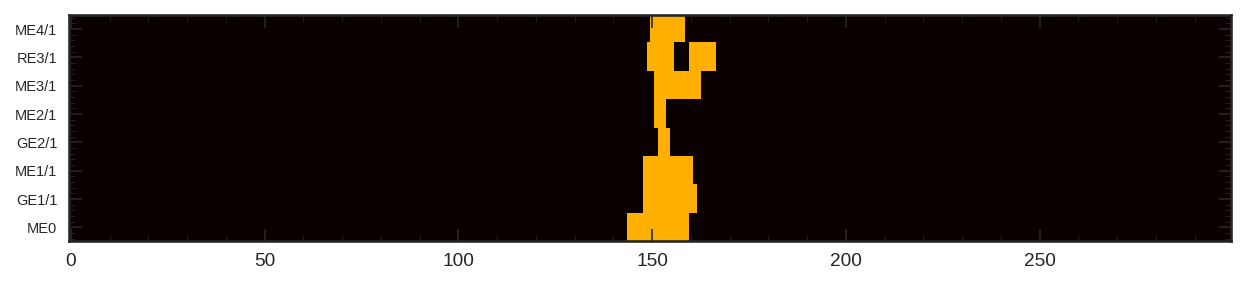

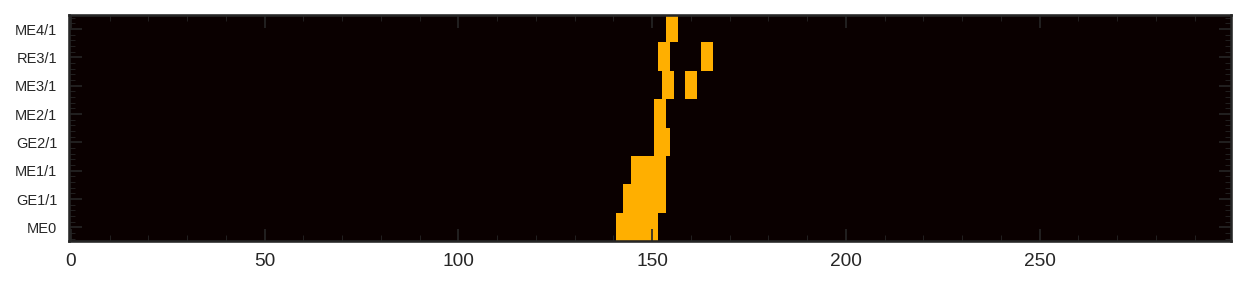

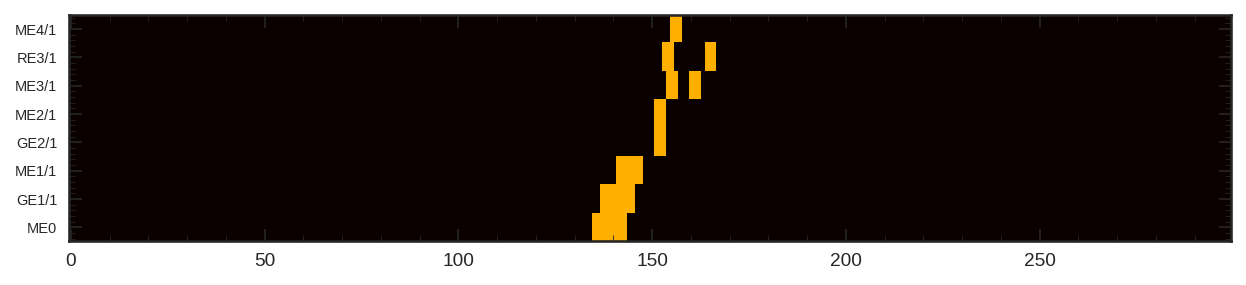

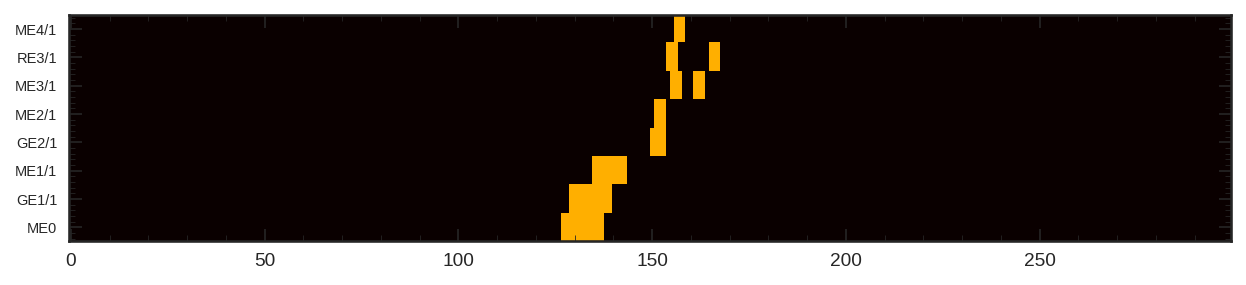

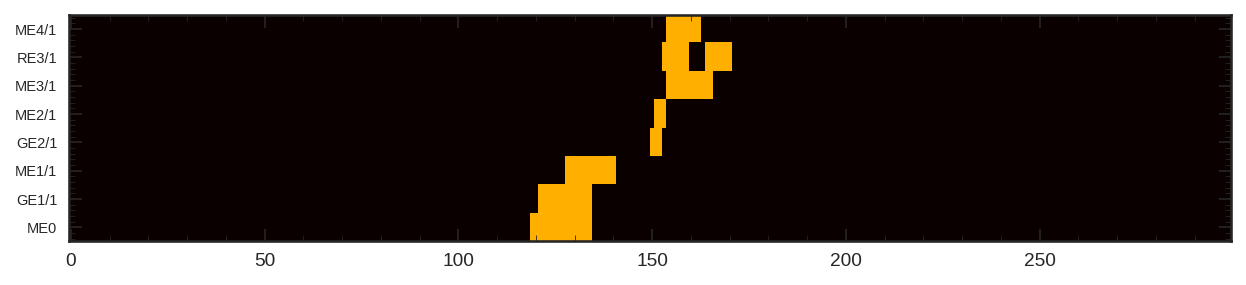

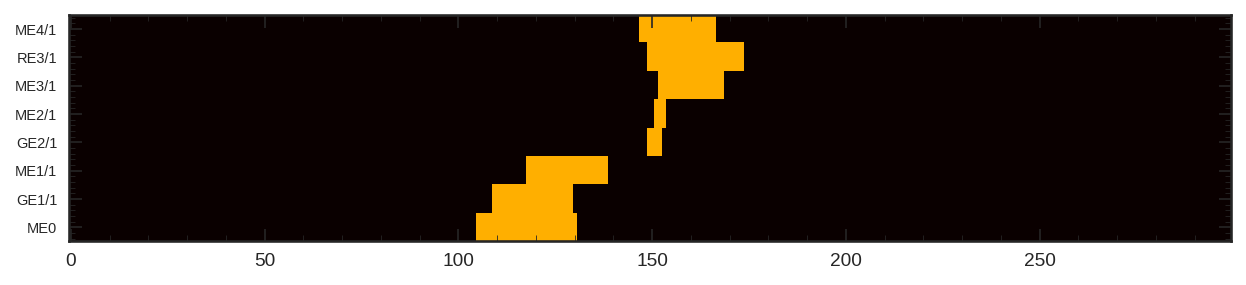

(array([0, 1, 2, 3, 4, 5, 5, 6, 6, 7]), array([139, 141, 144, 152, 152, 155, 161, 154, 165, 156]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7,
       7, 7]), array([135, 136, 137, 138, 139, 140, 141, 142, 143, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 141, 142, 143, 144, 145, 146, 147, 151,
       152, 153, 151, 152, 153, 154, 155, 156, 160, 161, 162, 153, 154,
       155, 164, 165, 166, 155, 156, 157]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]))


In [15]:
# Debug
for ievt in range(1):
  print('Event {0}'.format(ievt))
  display_image(zone_images_test[ievt])
  for j in range(zone_featmaps_test.shape[-1]):
    display_image(zone_featmaps_test[ievt][..., j:j+1], cmap=plt.cm.hot)

  print(zone_images_test[ievt].nonzero())
  print(zone_featmaps_test[ievt][..., 3:4].nonzero())

Event 2


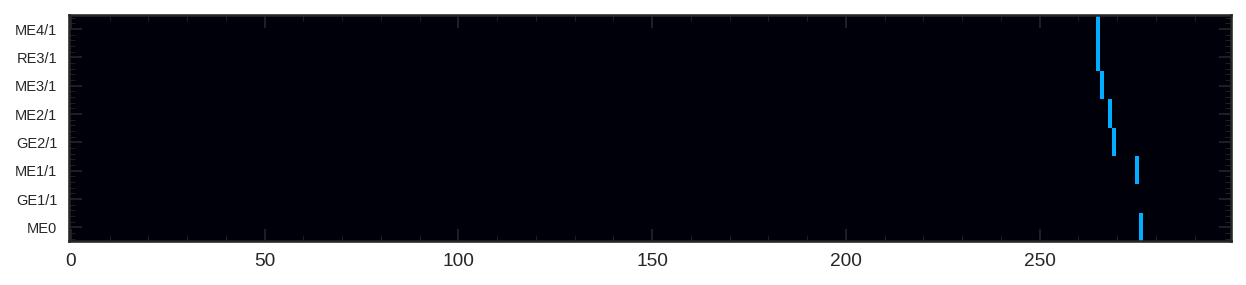

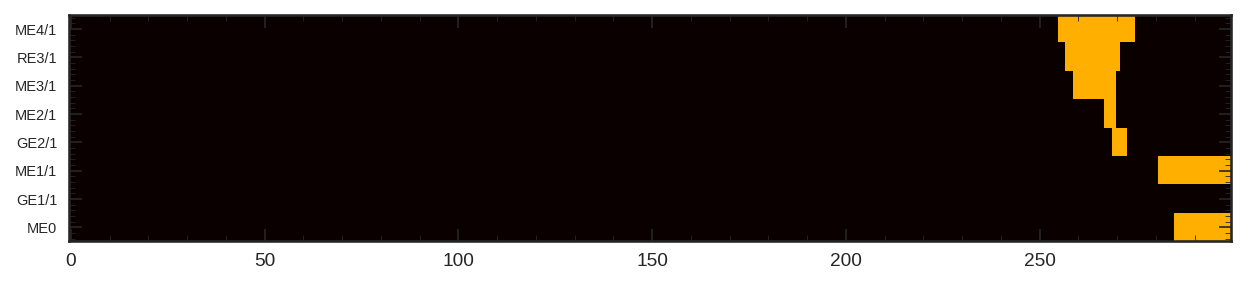

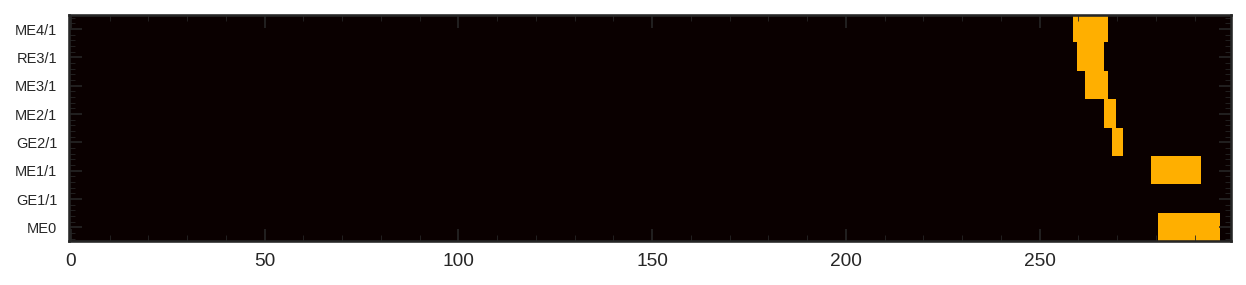

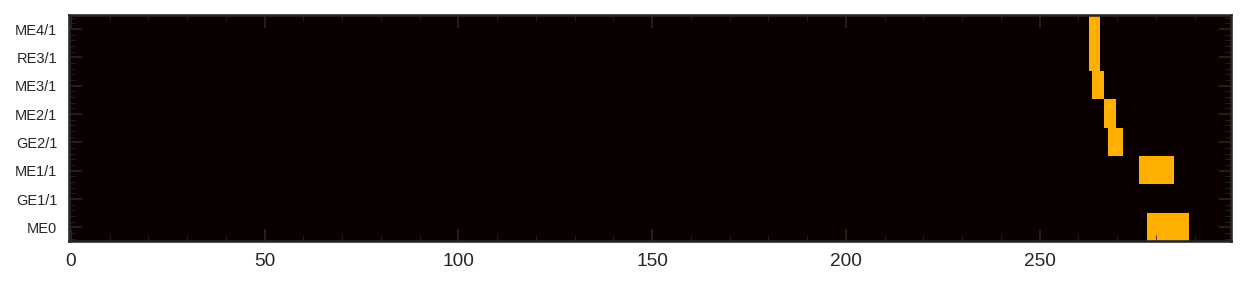

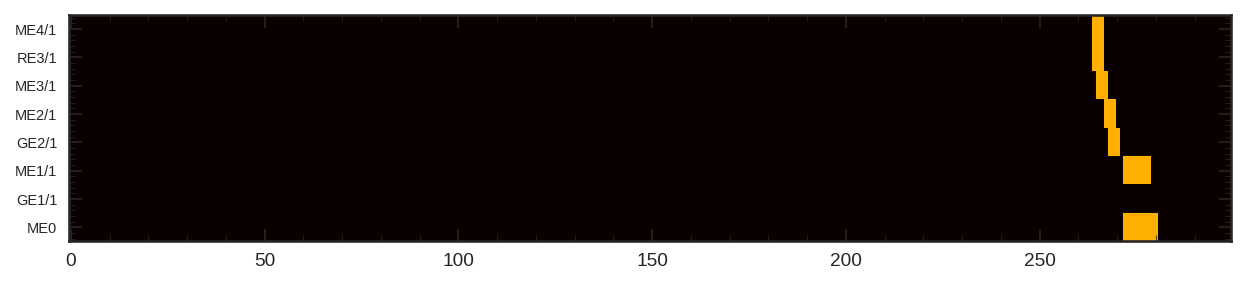

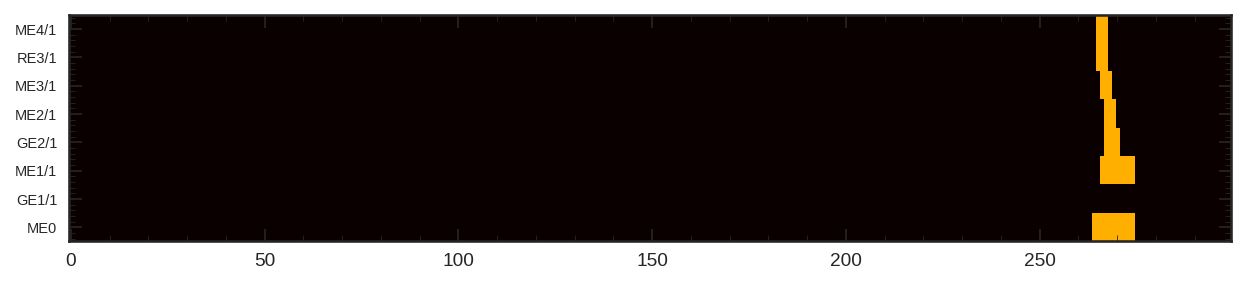

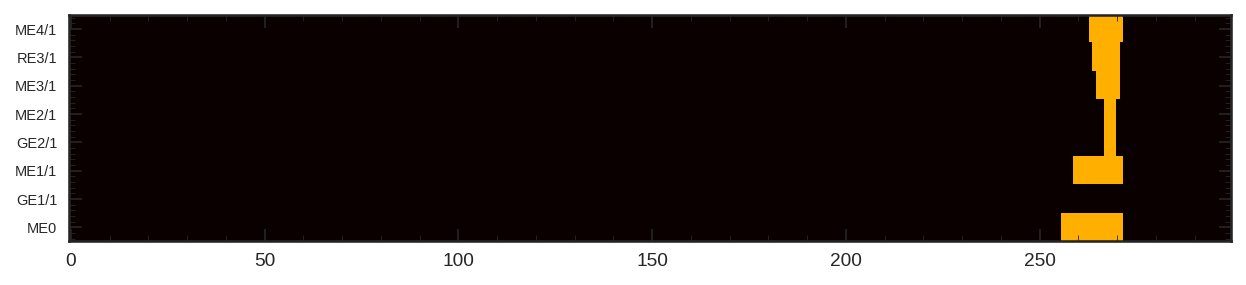

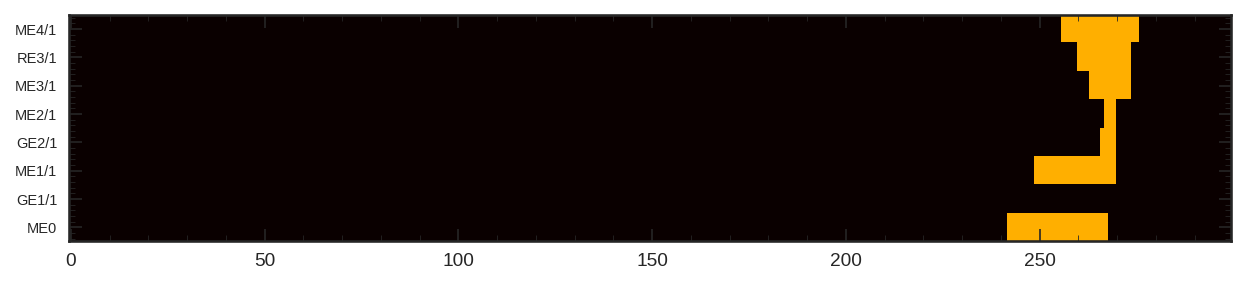

(array([0, 2, 3, 4, 5, 6, 7]), array([276, 275, 269, 268, 266, 265, 265]), array([0, 0, 0, 0, 0, 0, 0]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4,
       5, 5, 5, 6, 6, 6, 7, 7, 7]), array([272, 273, 274, 275, 276, 277, 278, 279, 280, 272, 273, 274, 275,
       276, 277, 278, 268, 269, 270, 267, 268, 269, 265, 266, 267, 264,
       265, 266, 264, 265, 266]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0]))


In [16]:
# Debug
for ievt in range(2,3):
  print('Event {0}'.format(ievt))
  display_image(zone_images_test[ievt])
  for j in range(zone_featmaps_test.shape[-1]):
    display_image(zone_featmaps_test[ievt][..., j:j+1], cmap=plt.cm.hot)

  print(zone_images_test[ievt].nonzero())
  print(zone_featmaps_test[ievt][..., 3:4].nonzero())

### Export data

In [17]:
for ievt in [0,1,2]:
  print('Event {0}'.format(ievt))
  s_img = dense_to_sparse(zone_images_test[ievt])
  s_fmap = dense_to_sparse(zone_featmaps_test[ievt])
  print('img. nnz: {0}'.format(s_img.indices.shape[0]))
  print(np.array2string(s_img.indices[:, 0], separator=', ', threshold=1000))
  print(np.array2string(s_img.indices[:, 1], separator=', ', threshold=1000))
  print(np.array2string(s_img.indices[:, 2], separator=', ', threshold=1000))
  print('fmap. nnz: {0}'.format(s_fmap.indices.shape[0]))
  print(np.array2string(s_fmap.indices[:, 0], separator=', ', threshold=1000))
  print(np.array2string(s_fmap.indices[:, 1], separator=', ', threshold=1000))
  print(np.array2string(s_fmap.indices[:, 2], separator=', ', threshold=1000))
  print()

Event 0
img. nnz: 10
[0, 1, 2, 3, 4, 5, 5, 6, 6, 7]
[139, 141, 144, 152, 152, 155, 161, 154, 165, 156]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fmap. nnz: 594
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
 2, 2, 2, 2, 2,